In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import re
import tensorflow as tf
from keras import layers,models

In [3]:
label={"abnormal":1,"normal":0}

In [5]:
SIZE=228
SIZE = 228
image_dataset = []
mask_dataset = []
y_label=[]
def load_images_from_folder(folder_path,images,x):
    os.chdir(folder_path)
    files = os.listdir()
    files.sort(key=lambda x: int(re.findall(r'\d+', x.split("(")[1])[0]))
    for filename in tqdm(files):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path,0)
            image = Image.fromarray(img)                   
            image = image.resize((SIZE, SIZE))
            images.append(np.array(image))
            y_label.append(label[x])

def load_masks_from_folder(folder_path,images):
    os.chdir(folder_path)
    files = os.listdir()
    files.sort(key=lambda x: int(re.findall(r'\d+', x.split("(")[1])[0]))
    for filename in tqdm(files):
        if filename.endswith(".jpg") or filename.endswith(".png"): 
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path,0)
            image = Image.fromarray(img)                    
            image = image.resize((96, 96))
            images.append(np.array(image))
folder_path = "/content/drive/MyDrive/data/database/abnormal" 
load_images_from_folder(folder_path,image_dataset,'abnormal')
folder_path = "/content/drive/MyDrive/data/labels/abnormal"
load_masks_from_folder(folder_path,mask_dataset)
folder_path = "/content/drive/MyDrive/data/database/normal"
load_images_from_folder(folder_path,image_dataset,'normal')
folder_path ="/content/drive/MyDrive/data/labels/normal"
load_masks_from_folder(folder_path,mask_dataset)
print(len(image_dataset))
print(len(mask_dataset))

100%|██████████| 500/500 [00:07<00:00, 68.93it/s] 

1000
1000


In [6]:
print("No of images :",len(image_dataset))
print("No of masks :",len(mask_dataset))

No of images : 1000
No of masks : 1000


In [7]:
print(image_dataset[1])

[[122 123 124 ... 124 121 119]
 [122 123 124 ... 122 118 115]
 [122 123 124 ... 120 114 111]
 ...
 [  4   4   4 ...  25  25  24]
 [  4   4   4 ...  25  24  24]
 [  4   4   4 ...  24  24  24]]


In [8]:
print(f'Image dataset sample output: \n{mask_dataset[1]}')
print(f'mask dataset sample output: \n{image_dataset[1]}')


Image dataset sample output: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask dataset sample output: 
[[122 123 124 ... 124 121 119]
 [122 123 124 ... 122 118 115]
 [122 123 124 ... 120 114 111]
 ...
 [  4   4   4 ...  25  25  24]
 [  4   4   4 ...  25  24  24]
 [  4   4   4 ...  24  24  24]]


In [9]:
image_dataset_norm = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
print(f'normalized mask dataset:\n {mask_dataset[1]}\n')
print(f'normalized image dataset:\n {image_dataset[1]}')


normalized mask dataset:
 [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]

normalized image dataset:
 [[122 123 124 ... 124 121 119]
 [122 123 124 ... 122 118 115]
 [122 123 124 ... 120 114 111]
 ...
 [  4   4   4 ...  25  25  24]
 [  4   4   4 ...  25  24  24]
 [  4   4   4 ...  24  24  24]]


In [11]:
import tensorflow as tf
from keras import layers,models


In [12]:
def unet(input_shape=(228, 228, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='valid')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='valid')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='valid')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='valid')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='valid')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='valid')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='valid')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='valid')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='valid')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='valid')(conv5)
    # Decoder
    up5 = layers.Conv2DTranspose(1024, 2, strides=(2, 2), padding='valid')(conv5)
    desired_size = (up5.shape[1], up5.shape[2])  # Desired output size
    c1 = tf.image.resize(conv4, desired_size, method=tf.image.ResizeMethod.BILINEAR)
    up5 = layers.concatenate([up5, c1], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up5)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='valid')(conv6)
    desired_size = (up6.shape[1], up6.shape[2])  # Desired output size
    c2 = tf.image.resize(conv3, desired_size, method=tf.image.ResizeMethod.BILINEAR)
    up6 = layers.concatenate([up6, c2], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv7)
    desired_size = (up5.shape[1], up5.shape[2])  # Desired output size
    c3 = tf.image.resize(conv2, desired_size, method=tf.image.ResizeMethod.BILINEAR)
    up7 = layers.concatenate([up7, c3], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='valid')(conv8)
    desired_size = (up5.shape[1], up5.shape[2])  # Desired output size
    c4 = tf.image.resize(conv1, desired_size, method=tf.image.ResizeMethod.BILINEAR)
    up8 = layers.concatenate([up8, c4], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = unet()
model.summary()

(None, 226, 226, 64)
(None, 224, 224, 64)
(None, 112, 112, 64)


(None, 110, 110, 128)
(None, 108, 108, 128)
(None, 54, 54, 128)


(None, 52, 52, 256)
(None, 50, 50, 256)
(None, 25, 25, 256)


(None, 23, 23, 512)
(None, 21, 21, 512)
(None, 10, 10, 512)


(None, 8, 8, 1024)
(None, 6, 6, 1024)


(None, 12, 12, 1024)
(None, 12, 12, 1536)
(None, 12, 12, 512)
(None, 12, 12, 512)


(None, 24, 24, 512)
(None, 24, 24, 768)
(None, 24, 24, 256)
(None, 24, 24, 256)


(None, 48, 48, 256)
(None, 48, 48, 384)
(None, 48, 48, 128)
(None, 48, 48, 128)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 228, 228, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 226, 226, 

In [13]:
from sklearn.model_selection import train_test_split
X_main, X_test, y_main, y_test = train_test_split(image_dataset_norm, mask_dataset, test_size = 0.15, random_state = 12)
val_size=0.15/(1-0.15)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size = val_size, random_state = 12)

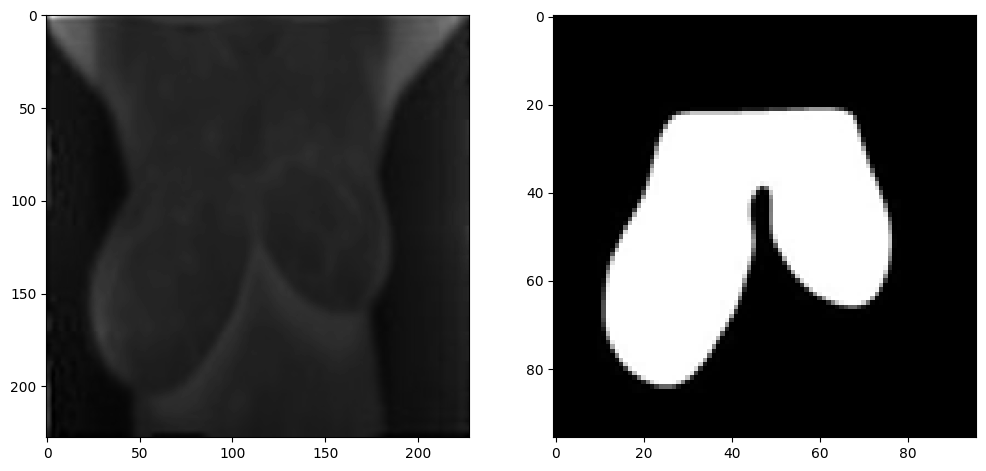

In [14]:
import random
import numpy as np
image_number = random.randint(0,len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset_norm[image_number], (228, 228)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (96, 96)), cmap='gray')
plt.show()

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'],run_eagerly=True)

In [16]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr *= 0.3  # Reduce learning rate by a factor of 0.3 every 10 epochs
        print(f'Reducing learning rate to: {lr}')
    return lr


lr_scheduler = LearningRateScheduler(scheduler)
hist1=model.fit(X_train, y_train, epochs=30, callbacks=[lr_scheduler],batch_size=8,validation_data=(X_val, y_val),shuffle=False)

Epoch 1/30


88/88 [==============================] - 63s 455ms/step - loss: 0.5133 - accuracy: 0.6954 - val_loss: 0.4277 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 2/30
88/88 [==============================] - 22s 250ms/step - loss: 0.2514 - accuracy: 0.8382 - val_loss: 0.1886 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 3/30
88/88 [==============================] - 23s 258ms/step - loss: 0.1504 - accuracy: 0.8801 - val_loss: 0.1080 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 4/30
88/88 [==============================] - 23s 260ms/step - loss: 0.1201 - accuracy: 0.8908 - val_loss: 0.0852 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 5/30
88/88 [==============================] - 23s 265ms/step - loss: 0.0843 - accuracy: 0.9020 - val_loss: 0.0739 - val_accuracy: 0.9042 - lr: 0.0010
Epoch 6/30
88/88 [==============================] - 22s 252ms/step - loss: 0.0666 - accuracy: 0.9071 - val_loss: 0.0563 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 7/30
88/88 [==============================] - 23s 267ms/step - loss: 

In [17]:
model.save('/content/drive/MyDrive/u-net1.keras')

In [18]:
_, acc = model.evaluate(X_val, y_val)
print("Accuracy = ", (acc * 100.0), "%")

5/5 [==============================] - 22s 2s/step - loss: 0.0224 - accuracy: 0.9160
Accuracy =  91.60301089286804 %


In [19]:
y_pred=model.predict(X_test)
print(y_pred[:3])

5/5 [==============================] - 1s 216ms/step
[[[[5.0381804e-10]
   [1.2852849e-15]
   [2.3306884e-17]
   ...
   [2.0812081e-11]
   [5.6556293e-10]
   [1.0501727e-06]]

  [[6.8572302e-13]
   [4.7855739e-21]
   [9.3666870e-23]
   ...
   [1.7980390e-15]
   [1.2874754e-12]
   [7.7187083e-09]]

  [[3.3753656e-14]
   [5.5413972e-21]
   [8.7510105e-25]
   ...
   [1.9346508e-16]
   [1.8640432e-14]
   [9.6996855e-10]]

  ...

  [[1.9748821e-07]
   [2.3544342e-11]
   [8.1848825e-12]
   ...
   [8.4174287e-26]
   [9.5460374e-23]
   [3.5925844e-18]]

  [[7.3014363e-08]
   [7.5462666e-12]
   [1.9946393e-13]
   ...
   [3.0999879e-28]
   [1.0849590e-24]
   [6.0400869e-18]]

  [[1.6165409e-06]
   [8.6897523e-10]
   [1.2136731e-11]
   ...
   [1.2648078e-23]
   [1.1991573e-20]
   [3.0760455e-13]]]


 [[[9.7607860e-09]
   [2.4968325e-13]
   [8.8277011e-15]
   ...
   [1.5528677e-19]
   [1.1035761e-16]
   [6.7450302e-11]]

  [[3.0685246e-11]
   [4.5432721e-18]
   [2.5983925e-19]
   ...
   [6.0967042

In [20]:
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.868855913452826


In [21]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

1/1 [==============================] - 2s 2s/step


In [23]:
test_img_other = cv2.imread("/content/drive/MyDrive/data/database/abnormal/abnormal_image (1).jpg", 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other = Image.fromarray(test_img_other)                    # Convert the image array to a PIL Image object
test_img_other = test_img_other.resize((SIZE, SIZE))
test_img_other=np.array(test_img_other)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

1/1 [==============================] - 0s 70ms/step


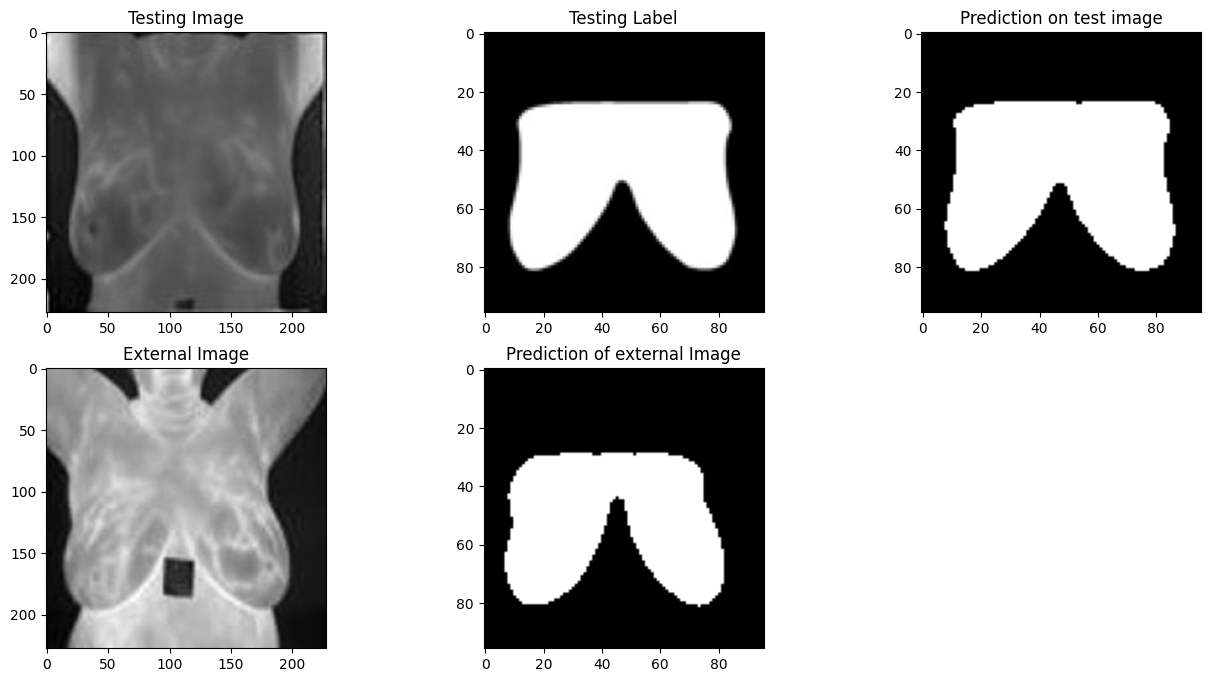

In [24]:
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

In [25]:
y_mask=model.predict(image_dataset_norm)

32/32 [==============================] - 7s 227ms/step


In [29]:
y_mask=model.predict(image_dataset_norm)
mask1=[]
for i in y_mask:
  a= cv2.resize(i, (228, 228), interpolation=cv2.INTER_CUBIC)
  mask1.append(np.array(a))
import numpy as np
new=[]
for i in range(0,len(mask_dataset)):
    threshold = 0.5
    masks=mask1[i]
    masks=  (masks> threshold).astype(int) *255
    masks = masks.astype(np.uint8)
    segmented_image_array = cv2.bitwise_and(image_dataset[i],image_dataset[i] , mask=masks)
    new.append(segmented_image_array)




In [30]:
import numpy as np
new=[]
for i in range(0,len(mask_dataset)):
    threshold = 0.5
    #image_dataset[i] = image_dataset[i].astype(np.uint8)
    masks=mask1[i]
    masks=  (masks> threshold).astype(int) *255
    masks = masks.astype(np.uint8)
    segmented_image_array = cv2.bitwise_and(image_dataset[i],image_dataset[i] , mask=masks)
    new.append(segmented_image_array)

In [31]:
new[1].shape

(228, 228)

In [32]:
print(new[1])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
unique_values = np.unique(new[1])

# Now 'unique_values' contains the unique values present in the second segmented image array
print(unique_values)

[  0 124 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205]


In [34]:
rgb_image = cv2.cvtColor(new[1], cv2.COLOR_GRAY2BGR)

print(rgb_image.shape)


(228, 228, 3)


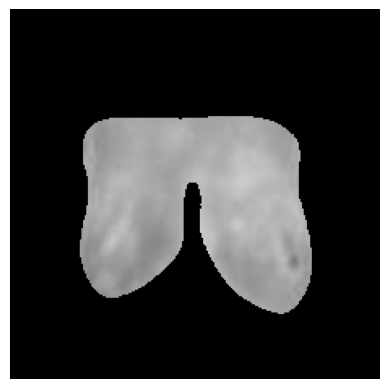

In [35]:
import matplotlib.pyplot as plt

# Assuming 'array_image' is your NumPy array representing the image
# Display the image using Matplotlib
plt.imshow(rgb_image )
plt.axis('off')  # Optional: turn off axis
plt.show()

In [36]:
segment=[]
for i in new:
  rgb_image = cv2.cvtColor(i, cv2.COLOR_GRAY2BGR)
  segment.append(rgb_image)

In [37]:
segment[1].shape

(228, 228, 3)

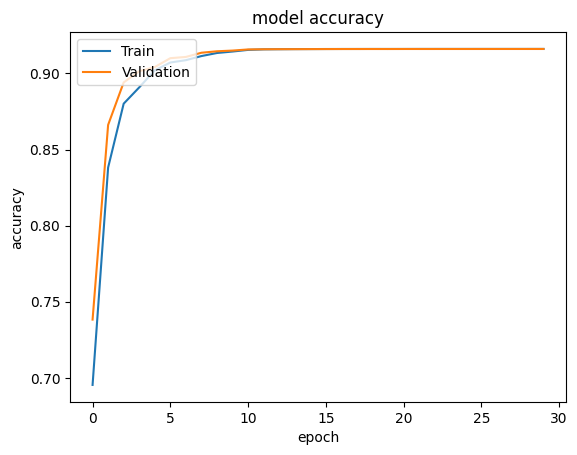

In [64]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

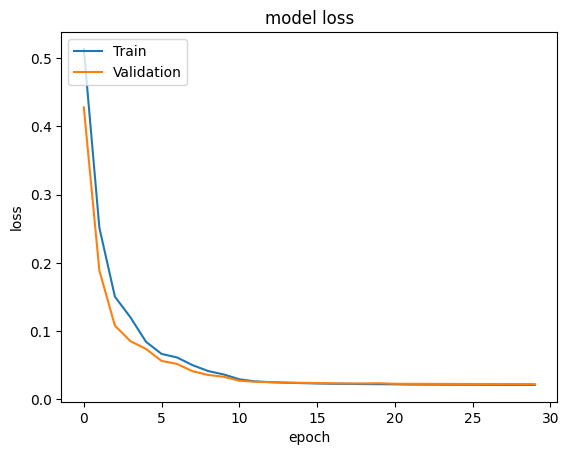

In [63]:
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Activation,Conv2D,MaxPooling2D,ZeroPadding2D

In [39]:
def create_model(input_shape):
    model = Sequential([
    Conv2D(64, (7, 7), strides=(6, 6), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    ZeroPadding2D(padding=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(256, (3, 3), activation='relu'),
    Dropout(0.25),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(256, (3, 3), activation='relu'),
    ZeroPadding2D(padding=(1, 1)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Adding dropout with a rate of 0.5
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Adding dropout with a rate of 0.5
    Dense(2, activation='softmax')

  ])
    return model

input_shape = (228, 228, 3)
cnn_model = create_model(input_shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 37, 37, 64)        9472      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 18, 18, 64)        0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)       0

In [40]:
from keras.optimizers import Adam
cnn_model.compile(optimizer=Adam(learning_rate=2.0e-3),loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
X=np.array(segment)
X=X.astype("float")
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,Y ,
                                   random_state=12,
                                   test_size=0.15,
                                   shuffle=True)
X_train2, X_val, y_train2, y_val = train_test_split(X_train1,y_train1 ,
                                   random_state=12,
                                   test_size=(0.15/(1-0.15)),
                                   shuffle=True)
cnn_hist=cnn_model.fit(X_train2, y_train2, epochs=30, batch_size=60, verbose=1, validation_data=(X_val, y_val))

In [41]:
X=np.array(segment)
X=X.astype("float")

In [42]:
X=np.array(segment)
X=X.astype("float")

In [43]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,Y ,
                                   random_state=12,
                                   test_size=0.15,
                                   shuffle=True)
X_train2, X_val, y_train2, y_val = train_test_split(X_train1,y_train1 ,
                                   random_state=12,
                                   test_size=(0.15/(1-0.15)),
                                   shuffle=True)

In [65]:
cnn_hist=cnn_model.fit(X_train2, y_train2, epochs=30, batch_size=60, verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
12/12 [==============================] - 1s 110ms/step - loss: 0.0320 - accuracy: 0.9914 - val_loss: 0.0093 - val_accuracy: 0.9933
Epoch 2/30
12/12 [==============================] - 1s 103ms/step - loss: 0.0246 - accuracy: 0.9957 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/30
12/12 [==============================] - 1s 72ms/step - loss: 0.0397 - accuracy: 0.9943 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 4/30
12/12 [==============================] - 1s 53ms/step - loss: 0.0305 - accuracy: 0.9914 - val_loss: 0.0132 - val_accuracy: 0.9933
Epoch 5/30
12/12 [==============================] - 1s 47ms/step - loss: 0.0498 - accuracy: 0.9929 - val_loss: 0.0502 - val_accuracy: 0.9933
Epoch 6/30
12/12 [==============================] - 1s 46ms/step - loss: 0.0339 - accuracy: 0.9943 - val_loss: 0.0185 - val_accuracy: 0.9867
Epoch 7/30
12/12 [==============================] - 1s 47ms/step - loss: 0.2055 - accuracy: 0.9686 - val_loss: 0.0355 - val_accuracy: 0.9933
Epoch 8/30


In [66]:
_, acc =cnn_model.evaluate(X_val,y_val)
print("Accuracy = ", (acc * 100.0), "%")

5/5 [==============================] - 0s 19ms/step - loss: 0.0225 - accuracy: 0.9933
Accuracy =  99.33333396911621 %


In [67]:
final_pred=cnn_model.predict(X_test1)
predict=np.argmax(final_pred[:1])
predict

5/5 [==============================] - 0s 12ms/step


0

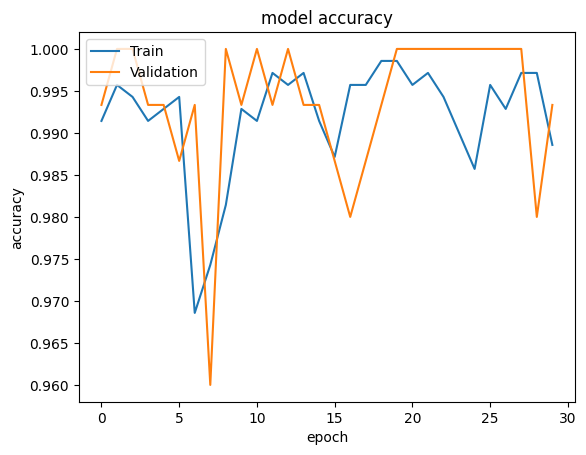

In [69]:
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

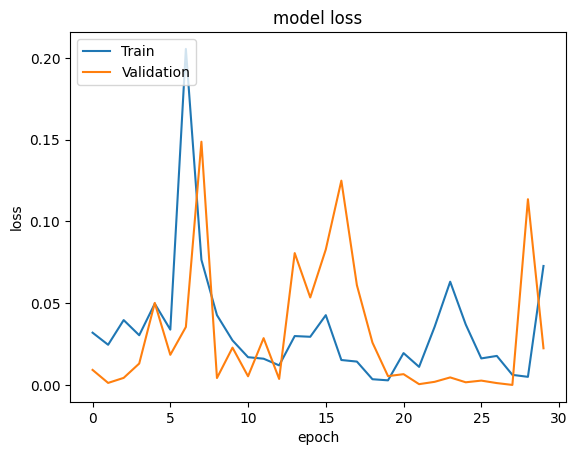

In [68]:
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
y=[]
for i in range(0,len(final_pred)):
    predict=np.argmax(final_pred[i])
    y.append(predict)

In [48]:
from sklearn.metrics import classification_report,confusion_matrix
target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(y_test1, y, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99        79
     Class 1       1.00      0.99      0.99        71

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [56]:
con=confusion_matrix(y,y_test1)
print(con)

[[79  1]
 [ 0 70]]


<Axes: >

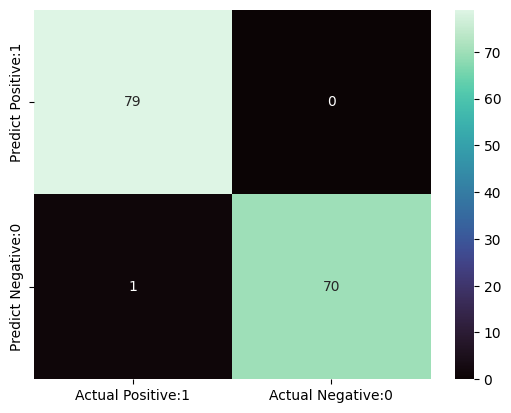

In [50]:
import pandas as pd
import seaborn as sns
cm_matrix = pd.DataFrame(data=con, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d',cmap='mako')

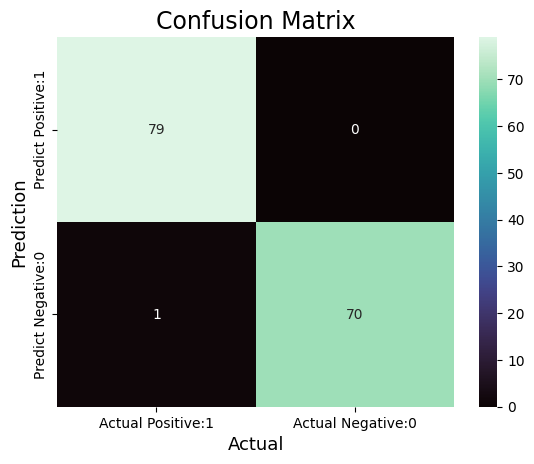

In [60]:
sns.heatmap(cm_matrix,
            annot=True,
            fmt='g',
            cmap='mako',
            xticklabels=['Actual Positive:1', 'Actual Negative:0'],
            yticklabels=['Predict Positive:1', 'Predict Negative:0'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [62]:
sensitivity = con[1][1] / (con[1][1] + con[1][0])

print("Sensitivity:", sensitivity*100)

sepcificity= con[0][0]/(con[0][0]+con[0][1])

print("Sepcificity:", sepcificity*100)

Sensitivity: 100.0
Sepcificity: 98.75


In [54]:
from sklearn import metrics
targs=y_test1
preds=y
#print("accuracy: ", metrics.accuracy_score(targs, preds))
p=metrics.precision_score(targs, preds)
print("precision: ",p*100,"%" )
r=metrics.recall_score(targs, preds)
print("recall: ", r*100,"%")
f1=metrics.f1_score(targs, preds)
print("f1: ",f1*100,"%")
auc= metrics.roc_auc_score(targs, preds)
print("area under curve (auc): ", auc*100,"%")


precision:  100.0 %
recall:  98.59154929577466 %
f1:  99.29078014184397 %
area under curve (auc):  99.29577464788733 %


In [74]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(targs, preds)
roc_auc = auc(fpr, tpr)
roc_auc

0.9929577464788732

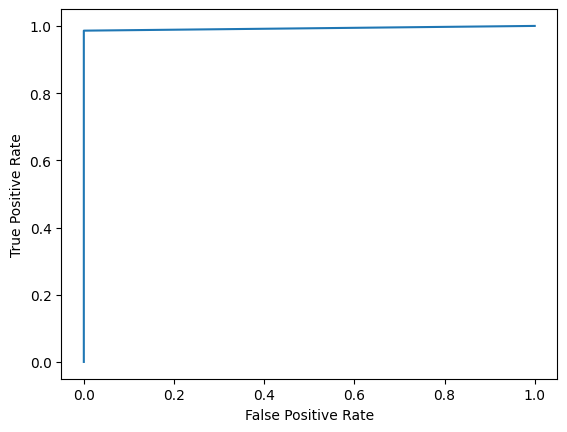

In [75]:
from sklearn.metrics import roc_curve
fpr,tpr,_=roc_curve(targs, preds)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

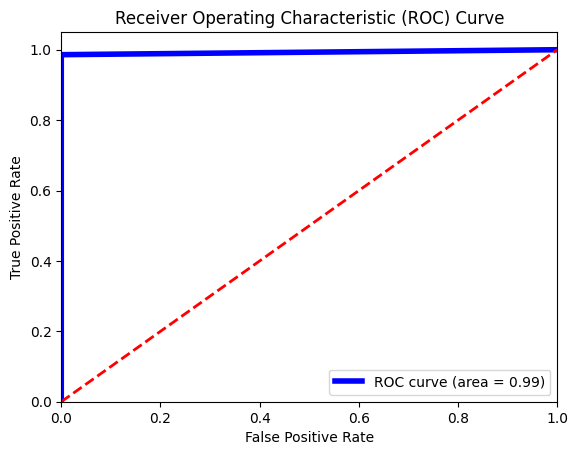

In [76]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=4, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()